# Import library

packages allowed for use during inference

In [25]:
import os
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms



import imageio.v2 as imageio
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import pandas as pd

from sklearn.manifold import TSNE

packages during training

In [26]:
from thop import profile

# Hyperparameters

In [27]:
BATCH_SIZE = 128
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define Custom Dataset

custom dataset

先計算此training dataset的mean & std (直接用imagenet的)

In [28]:
train_mean = [0.485, 0.456, 0.406]
train_std = [0.229, 0.224, 0.225]

Custom dataset

In [29]:
# dataset整理image & label (from image folder & csv file)
class CustomDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.data_frame = pd.read_csv(csv_file) #csv_file : csv file path
        self.root_dir = root_dir #train folder 位置
        self.transform = transform

    def __len__(self):
        return len(self.data_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.data_frame.iloc[idx, 1])
        image = Image.open(img_name).convert("RGB") #image is PIL image
        label = int(self.data_frame.iloc[idx, 2])  # Get the label
        
        if self.transform:
            image = self.transform(image)

        return image, label


建train transform和val transform

val transform和test transform一樣

In [30]:
# Data Transformations
transform_train = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomPerspective(distortion_scale=0.5, p=0.5),
    transforms.GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std),
    transforms.RandomErasing(p=0.3, scale=(0.02, 0.05), ratio=(0.3, 3.3), value=0)
])

transform_val = transforms.Compose([
    transforms.Resize(128),
    transforms.CenterCrop(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=train_mean, std=train_std),
])


用P2_train_val_CustomDataset產生custom train & val dataset，再產生trainloader & valloader

In [31]:
train_dataset = CustomDataset(csv_file='../../../hw1_data/p1_data/office/train.csv', root_dir='../../../hw1_data/p1_data/office/train', transform=transform_train)
val_dataset = CustomDataset(csv_file='../../../hw1_data/p1_data/office/val.csv', root_dir='../../../hw1_data/p1_data/office/val', transform=transform_val)

trainloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
valloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

In [32]:
# print shape
image_first_batch, label_first_batch = next(iter(trainloader))  #get first batch's image & mask
print("type(image_first_batch): ", type(image_first_batch))
print("image_first_batch.shape: ", image_first_batch.shape)
print("type(label_first_batch): ", type(label_first_batch))
print("label_first_batch.shape: ", label_first_batch.shape)

type(image_first_batch):  <class 'torch.Tensor'>
image_first_batch.shape:  torch.Size([128, 3, 128, 128])
type(label_first_batch):  <class 'torch.Tensor'>
label_first_batch.shape:  torch.Size([128])


In [33]:
print(image_first_batch[2][0][100][102])
print(label_first_batch[2])

tensor(2.1290)
tensor(6)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


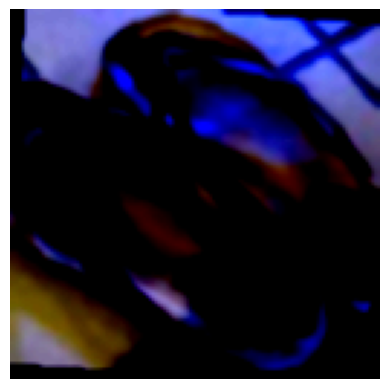

In [34]:
# visualize wo normalization
idx = 1
first_image = image_first_batch[idx]


# Convert the tensor to numpy array
image_np = first_image.numpy()
# Since matplotlib expects images in H x W x C format, we need to transpose it
image_np = np.transpose(image_np, (1, 2, 0))

# Plot the image
plt.imshow(image_np)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

In [35]:
print(torch.cuda.is_available())

True


# Build Model

instance model
 
並載入SSL訓練的WEIGHT


In [36]:
backbone = models.resnet50(weights=None)  # No pretrained weights
# Number of input features to the original FC layer
num_features = backbone.fc.in_features  # Typically 2048 for ResNet50 
print(num_features)
backbone.fc = torch.nn.Identity()  # Remove the final classification layer
backbone.load_state_dict(torch.load('../../../checkpoint_model/P1/SSL_pretrain_backbone/best_loss_model.pth'), strict=False) # load the backbone weights
print()

#backbone is on cpu

2048



/tmp/ipykernel_19257/2857827174.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  backbone.load_state_dict(torch.load('../../../checkpoint_model/P1/SSL_pretrain_backbone/b

 **C set:** train full model

 將resnet的fc替換成custom classifier 

In [37]:
# Create CombinedModel with custom classifier
class CombinedModel(nn.Module):
    def __init__(self, Backbone, num_features, hidden1=512, hidden2=256, num_classes=65, dropout_prob=0.5):
        super(CombinedModel, self).__init__()
        #Backbone
        self.Backbone = Backbone
        # First layer
        self.fc1 = nn.Linear(num_features, hidden1)
        self.bn1 = nn.BatchNorm1d(hidden1)  # Batch Normalization for first hidden layer
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(p=dropout_prob)  # Dropout after first hidden layer

        # Second layer
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.bn2 = nn.BatchNorm1d(hidden2)  # Batch Normalization for second hidden layer
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(p=dropout_prob)  # Dropout after second hidden layer

        # Final layer (output)
        self.fc3 = nn.Linear(hidden2, num_classes)

    def forward(self, x):
        # Backbone(already replace fc layer by identity)
        x = self.Backbone(x)
        # Forward through the first layer
        x = self.fc1(x)
        x = self.bn1(x)  # Batch normalization
        x = self.relu1(x)
        x = self.dropout1(x)  # Dropout
        
        # Forward through the second layer # Second Last layer(fc layer)
        x = self.fc2(x)
        x = self.bn2(x)  # Batch normalization
        x = self.relu2(x)
        x = self.dropout2(x)  # Dropout

        # Output layer (no activation, used for logits) # Last layer
        x = self.fc3(x)
        return x
    
    def get_second_last_layer_output(self, x):
        # Backbone(already replace fc layer by identity)
        x = self.Backbone(x)
        # Forward through the first layer
        x = self.fc1(x)
        x = self.bn1(x)  # Batch normalization
        x = self.relu1(x)
        x = self.dropout1(x)  # Dropout
        
        # Forward through the second layer (this is where we stop)
        x = self.fc2(x)
        x = self.bn2(x)  # Batch normalization
        x = self.relu2(x)
        x = self.dropout2(x)  # Dropout
        
        # Return the second-to-last layer output
        return x


# Replace the final fully connected layer in ResNet50 with the new MLP head
net = CombinedModel(Backbone=backbone, num_features=num_features)
net = net.to(device)


In [38]:
net.eval()
print(net)
#Compute MACs & params
input1 = torch.randn(1,3,128,128).to(device) # dummy input也放到device
MACs, params = profile(net, inputs=(input1, ))
print('MACs = ' + str(MACs/1000**3) + 'G')
print('Params = ' + str(params/1000**2) + 'M')

CombinedModel(
  (Backbone): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
   

In [39]:
#print output shape
input1 = torch.randn(1,3,128,128).to(device) # dummy input也放到device
output_secondlast = net.get_second_last_layer_output(input1)
output = net(input1)
print(output.shape)
print(output_secondlast.shape)

torch.Size([1, 65])
torch.Size([1, 256])


# Training

t-SNE

In [40]:
# get second-last layer outputs and corresponding labels
def get_tsne_data(net, loader, epoch, save_dir='./TSNE_feature_label'):
    net.eval()  # Set model to evaluation mode
    features = []
    labels_list = []

    with torch.no_grad():
        for inputs, labels in loader:
            inputs = inputs.to(device) 
            labels = labels.to(device) #(N)

            # Get the second-to-last layer output
            second_last_output = net.get_second_last_layer_output(inputs) # (N, 256)

            # Collect outputs and labels
            features.append(second_last_output.cpu().numpy())
            labels_list.append(labels.cpu().numpy())

    # Stack collected data
    features = np.vstack(features)
    labels_list = np.hstack(labels_list)

     # Save features and labels as .npy files
    os.makedirs(save_dir, exist_ok=True)
    feature_save_path = os.path.join(save_dir, f'features_epoch_{epoch}.npy')
    labels_save_path = os.path.join(save_dir, f'labels_epoch_{epoch}.npy')

    np.save(feature_save_path, features)
    np.save(labels_save_path, labels_list)
    
    print(f"Saved features and labels for epoch {epoch} to {save_dir}")
    return features, labels_list

In [41]:
def plot_tsne(features, labels, epoch, save_dir='./TSNE_plots'):
    tsne = TSNE(n_components=2, random_state=42)
    tsne_result = tsne.fit_transform(features)

    # Plot
    plt.figure(figsize=(10, 8))
    plt.scatter(tsne_result[:, 0], tsne_result[:, 1], c=labels, cmap='tab20', s=5)
    plt.colorbar()
    plt.title(f't-SNE Visualization - Epoch {epoch}')

    # Save the plot as an image
    save_path = os.path.join(save_dir, f'tsne_epoch_{epoch}.png')
    plt.savefig(save_path)
    print(f'Saved t-SNE plot for epoch {epoch} to {save_path}')

    plt.close()  # Close the plot to avoid display in interactive environments

Loss and Optimizer and epoch_n

In [42]:
# Loss function with label smoothing
class LabelSmoothingLoss(nn.Module):
    def __init__(self, num_classes, smoothing=0.0):
        super(LabelSmoothingLoss, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing
        self.num_classes = num_classes

    def forward(self, pred, target):
        # Convert target to one-hot format
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (self.num_classes - 1))
            true_dist.scatter_(1, target.data.unsqueeze(1), self.confidence)
        
        return torch.mean(torch.sum(-true_dist * torch.log_softmax(pred, dim=1), dim=1))

In [43]:
#criterion = nn.CrossEntropyLoss()
# Create Label Smoothing loss instance
criterion = LabelSmoothingLoss(num_classes=65, smoothing=0.1)
# Initialize optimizer
optimizer = optim.Adam(net.parameters(), lr=0.001, weight_decay=1e-4)
# Different base learning rate and update strategy #!!!!!!
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=5)  #if 5個epoch沒進步==> lr *= 0.5
#scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.6, last_epoch=-1)
# number of epoch
num_epochs = 100

training & validation loop

In [44]:
# Training and Validation Loop
best_val_acc = 0


for epoch in range(num_epochs):

    net.train() #開啟BN & DROPOUT
    train_loss = 0
    total_train = 0
    correct_train = 0

    for images, targets in tqdm(trainloader, desc=f'Epoch {epoch + 1}/{num_epochs}', unit='batch'):  #進度條以batch完成度為趴數
        
        images, targets = images.to(device), targets.to(device)# model, input image, output, mask(target, label, GT) are moved to GPU during training

        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()

        _, predicted = torch.max(outputs.data, 1)
        total_train += targets.size(0) #計算all dataset len
        correct_train += predicted.eq(targets.data).cpu().sum()

    train_loss /= len(trainloader)
    acc1 = correct_train / total_train



    # Validate
    net.eval() #關掉BN & DROPOUT
    val_loss = 0
    total_val = 0
    correct_val = 0

    with torch.no_grad():
        for images, targets in tqdm(valloader, desc='Validation', unit='batch'):
            images, targets = images.to(device), targets.to(device)

            outputs = net(images)  #(bs, 7, 512, 512)
            loss = criterion(outputs, targets) 


            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            total_val += targets.size(0) #計算all dataset len
            correct_val += predicted.eq(targets.data).cpu().sum()

    
    val_loss /= len(valloader)
    acc2 = correct_val / total_val
    
    # Save best model
    if acc2 > best_val_acc:
        best_val_acc = acc2
        torch.save(net.state_dict(), os.path.join("../../../", "checkpoint_model", "P1", "Fine_tune", "C", "best_val_acc_model.pth"))
        print(f'Saved best model with val acc: {acc2:.4f}')


    scheduler.step(acc2)


    # Logging
    print(f'Epoch {epoch + 1}/{num_epochs} - Train Loss: {train_loss:.4f} - Train acc: {acc1:.4f} - Val Loss: {val_loss:.4f} - Val acc: {acc2:.4f}')
    print(f'Learning rate: {scheduler.get_last_lr()[0]}')
    

    # Save t-SNE visualization and features for first and last epochs
    if epoch == 0 or epoch == num_epochs - 1:
        print(f"Saving t-SNE and features at epoch {epoch + 1}...")
        features, labels = get_tsne_data(net, trainloader, epoch + 1)
        plot_tsne(features, labels, epoch + 1)

Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.42s/batch]


Saved best model with val acc: 0.0345
Epoch 1/100 - Train Loss: 4.2489 - Train acc: 0.0286 - Val Loss: 4.1262 - Val acc: 0.0345
Learning rate: 0.001
Saving t-SNE and features at epoch 1...
Saved features and labels for epoch 1 to ./TSNE_feature_label
Saved t-SNE plot for epoch 1 to ./TSNE_plots/tsne_epoch_1.png


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.40s/batch]


Saved best model with val acc: 0.0419
Epoch 2/100 - Train Loss: 4.1375 - Train acc: 0.0448 - Val Loss: 4.0552 - Val acc: 0.0419
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.38s/batch]


Saved best model with val acc: 0.0468
Epoch 3/100 - Train Loss: 4.0895 - Train acc: 0.0519 - Val Loss: 4.0504 - Val acc: 0.0468
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.39s/batch]


Epoch 4/100 - Train Loss: 4.0797 - Train acc: 0.0486 - Val Loss: 4.0358 - Val acc: 0.0419
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.39s/batch]


Saved best model with val acc: 0.0616
Epoch 5/100 - Train Loss: 4.0408 - Train acc: 0.0569 - Val Loss: 3.9974 - Val acc: 0.0616
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.39s/batch]


Epoch 6/100 - Train Loss: 3.9971 - Train acc: 0.0661 - Val Loss: 3.9575 - Val acc: 0.0567
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.38s/batch]


Epoch 7/100 - Train Loss: 3.9646 - Train acc: 0.0709 - Val Loss: 3.9748 - Val acc: 0.0493
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.39s/batch]


Saved best model with val acc: 0.0665
Epoch 8/100 - Train Loss: 3.9469 - Train acc: 0.0656 - Val Loss: 3.8908 - Val acc: 0.0665
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.38s/batch]


Saved best model with val acc: 0.0887
Epoch 9/100 - Train Loss: 3.9170 - Train acc: 0.0757 - Val Loss: 3.8236 - Val acc: 0.0887
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.38s/batch]


Epoch 10/100 - Train Loss: 3.9054 - Train acc: 0.0795 - Val Loss: 3.8576 - Val acc: 0.0739
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.38s/batch]


Epoch 11/100 - Train Loss: 3.8751 - Train acc: 0.0843 - Val Loss: 3.8542 - Val acc: 0.0591
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.38s/batch]


Saved best model with val acc: 0.0985
Epoch 12/100 - Train Loss: 3.8636 - Train acc: 0.0926 - Val Loss: 3.7317 - Val acc: 0.0985
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.38s/batch]


Saved best model with val acc: 0.1084
Epoch 13/100 - Train Loss: 3.8259 - Train acc: 0.0987 - Val Loss: 3.6989 - Val acc: 0.1084
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.38s/batch]


Epoch 14/100 - Train Loss: 3.8059 - Train acc: 0.1104 - Val Loss: 3.7645 - Val acc: 0.1034
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.39s/batch]


Epoch 15/100 - Train Loss: 3.7986 - Train acc: 0.1053 - Val Loss: 3.7806 - Val acc: 0.0936
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.39s/batch]


Epoch 16/100 - Train Loss: 3.7748 - Train acc: 0.1025 - Val Loss: 3.6159 - Val acc: 0.1059
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.39s/batch]


Saved best model with val acc: 0.1330
Epoch 17/100 - Train Loss: 3.7358 - Train acc: 0.1174 - Val Loss: 3.6301 - Val acc: 0.1330
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.40s/batch]


Epoch 18/100 - Train Loss: 3.7152 - Train acc: 0.1233 - Val Loss: 3.6737 - Val acc: 0.1158
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.39s/batch]


Epoch 19/100 - Train Loss: 3.7044 - Train acc: 0.1222 - Val Loss: 3.5721 - Val acc: 0.1207
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.38s/batch]


Epoch 20/100 - Train Loss: 3.6779 - Train acc: 0.1220 - Val Loss: 3.7402 - Val acc: 0.1108
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.39s/batch]


Saved best model with val acc: 0.1404
Epoch 21/100 - Train Loss: 3.6379 - Train acc: 0.1319 - Val Loss: 3.5320 - Val acc: 0.1404
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.40s/batch]


Epoch 22/100 - Train Loss: 3.6264 - Train acc: 0.1443 - Val Loss: 3.7433 - Val acc: 0.1281
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.39s/batch]


Saved best model with val acc: 0.1675
Epoch 23/100 - Train Loss: 3.5973 - Train acc: 0.1438 - Val Loss: 3.4808 - Val acc: 0.1675
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.39s/batch]


Epoch 24/100 - Train Loss: 3.5743 - Train acc: 0.1569 - Val Loss: 3.6457 - Val acc: 0.1084
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.41s/batch]


Saved best model with val acc: 0.1749
Epoch 25/100 - Train Loss: 3.5285 - Train acc: 0.1648 - Val Loss: 3.5356 - Val acc: 0.1749
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.38s/batch]


Epoch 26/100 - Train Loss: 3.5161 - Train acc: 0.1607 - Val Loss: 3.7364 - Val acc: 0.1355
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.39s/batch]


Epoch 27/100 - Train Loss: 3.4914 - Train acc: 0.1663 - Val Loss: 3.4047 - Val acc: 0.1552
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.38s/batch]


Saved best model with val acc: 0.1823
Epoch 28/100 - Train Loss: 3.4707 - Train acc: 0.1749 - Val Loss: 3.4162 - Val acc: 0.1823
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.38s/batch]


Saved best model with val acc: 0.2143
Epoch 29/100 - Train Loss: 3.4577 - Train acc: 0.1653 - Val Loss: 3.3919 - Val acc: 0.2143
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.41s/batch]


Epoch 30/100 - Train Loss: 3.4514 - Train acc: 0.1800 - Val Loss: 3.3304 - Val acc: 0.2020
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.46s/batch]


Epoch 31/100 - Train Loss: 3.4031 - Train acc: 0.1878 - Val Loss: 3.2569 - Val acc: 0.1946
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.43s/batch]


Epoch 32/100 - Train Loss: 3.3755 - Train acc: 0.1931 - Val Loss: 3.2093 - Val acc: 0.2044
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.40s/batch]


Epoch 33/100 - Train Loss: 3.3445 - Train acc: 0.2022 - Val Loss: 3.4899 - Val acc: 0.1970
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.41s/batch]


Epoch 34/100 - Train Loss: 3.3322 - Train acc: 0.2149 - Val Loss: 3.3650 - Val acc: 0.1897
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.41s/batch]


Saved best model with val acc: 0.2562
Epoch 35/100 - Train Loss: 3.3074 - Train acc: 0.2118 - Val Loss: 3.2059 - Val acc: 0.2562
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.39s/batch]


Epoch 36/100 - Train Loss: 3.2970 - Train acc: 0.2174 - Val Loss: 3.1543 - Val acc: 0.2241
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.42s/batch]


Saved best model with val acc: 0.2882
Epoch 37/100 - Train Loss: 3.2602 - Train acc: 0.2301 - Val Loss: 3.1080 - Val acc: 0.2882
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.40s/batch]


Epoch 38/100 - Train Loss: 3.2262 - Train acc: 0.2298 - Val Loss: 3.2519 - Val acc: 0.2340
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.39s/batch]


Epoch 39/100 - Train Loss: 3.2332 - Train acc: 0.2285 - Val Loss: 3.2451 - Val acc: 0.2488
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.38s/batch]


Epoch 40/100 - Train Loss: 3.1650 - Train acc: 0.2478 - Val Loss: 3.1793 - Val acc: 0.2537
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.38s/batch]


Epoch 41/100 - Train Loss: 3.1823 - Train acc: 0.2440 - Val Loss: 3.1543 - Val acc: 0.2808
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.39s/batch]


Epoch 42/100 - Train Loss: 3.1432 - Train acc: 0.2554 - Val Loss: 3.1382 - Val acc: 0.2709
Learning rate: 0.001


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.38s/batch]


Epoch 43/100 - Train Loss: 3.1130 - Train acc: 0.2632 - Val Loss: 3.0640 - Val acc: 0.2808
Learning rate: 0.0005


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.39s/batch]


Saved best model with val acc: 0.3473
Epoch 44/100 - Train Loss: 3.0383 - Train acc: 0.2845 - Val Loss: 2.9919 - Val acc: 0.3473
Learning rate: 0.0005


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.39s/batch]


Epoch 45/100 - Train Loss: 2.9838 - Train acc: 0.3080 - Val Loss: 3.0080 - Val acc: 0.3054
Learning rate: 0.0005


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.39s/batch]


Epoch 46/100 - Train Loss: 2.9644 - Train acc: 0.3009 - Val Loss: 2.9180 - Val acc: 0.3276
Learning rate: 0.0005


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.39s/batch]


Epoch 47/100 - Train Loss: 2.9502 - Train acc: 0.3085 - Val Loss: 2.9384 - Val acc: 0.3227
Learning rate: 0.0005


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.40s/batch]


Epoch 48/100 - Train Loss: 2.9322 - Train acc: 0.3194 - Val Loss: 2.9100 - Val acc: 0.3251
Learning rate: 0.0005


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.39s/batch]


Epoch 49/100 - Train Loss: 2.9236 - Train acc: 0.3093 - Val Loss: 2.9312 - Val acc: 0.3005
Learning rate: 0.0005


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.39s/batch]


Epoch 50/100 - Train Loss: 2.8916 - Train acc: 0.3278 - Val Loss: 2.9053 - Val acc: 0.3227
Learning rate: 0.00025


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.42s/batch]


Epoch 51/100 - Train Loss: 2.8585 - Train acc: 0.3343 - Val Loss: 2.8247 - Val acc: 0.3325
Learning rate: 0.00025


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.39s/batch]


Epoch 52/100 - Train Loss: 2.8018 - Train acc: 0.3528 - Val Loss: 2.8520 - Val acc: 0.3399
Learning rate: 0.00025


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.38s/batch]


Saved best model with val acc: 0.3596
Epoch 53/100 - Train Loss: 2.7816 - Train acc: 0.3543 - Val Loss: 2.8512 - Val acc: 0.3596
Learning rate: 0.00025


Validation: 100%|██████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.40s/batch]


Saved best model with val acc: 0.3645
Epoch 54/100 - Train Loss: 2.7786 - Train acc: 0.3635 - Val Loss: 2.7814 - Val acc: 0.3645
Learning rate: 0.00025


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.41s/batch]


Epoch 55/100 - Train Loss: 2.7520 - Train acc: 0.3632 - Val Loss: 2.8045 - Val acc: 0.3645
Learning rate: 0.00025


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.39s/batch]


Saved best model with val acc: 0.3719
Epoch 56/100 - Train Loss: 2.7253 - Train acc: 0.3802 - Val Loss: 2.8189 - Val acc: 0.3719
Learning rate: 0.00025


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.46s/batch]


Epoch 57/100 - Train Loss: 2.7266 - Train acc: 0.3731 - Val Loss: 2.7782 - Val acc: 0.3473
Learning rate: 0.00025


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.45s/batch]


Epoch 58/100 - Train Loss: 2.7104 - Train acc: 0.3842 - Val Loss: 2.7675 - Val acc: 0.3596
Learning rate: 0.00025


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.44s/batch]


Epoch 59/100 - Train Loss: 2.6656 - Train acc: 0.3915 - Val Loss: 2.7484 - Val acc: 0.3596
Learning rate: 0.00025


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.44s/batch]


Epoch 60/100 - Train Loss: 2.6643 - Train acc: 0.3964 - Val Loss: 2.8028 - Val acc: 0.3719
Learning rate: 0.00025


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.46s/batch]


Epoch 61/100 - Train Loss: 2.6520 - Train acc: 0.3943 - Val Loss: 2.7946 - Val acc: 0.3498
Learning rate: 0.00025


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.46s/batch]


Saved best model with val acc: 0.3818
Epoch 62/100 - Train Loss: 2.6358 - Train acc: 0.4039 - Val Loss: 2.7353 - Val acc: 0.3818
Learning rate: 0.00025


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.44s/batch]


Epoch 63/100 - Train Loss: 2.6189 - Train acc: 0.4103 - Val Loss: 2.7245 - Val acc: 0.3596
Learning rate: 0.00025


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.41s/batch]


Saved best model with val acc: 0.3842
Epoch 64/100 - Train Loss: 2.5994 - Train acc: 0.4133 - Val Loss: 2.7337 - Val acc: 0.3842
Learning rate: 0.00025


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.39s/batch]


Epoch 65/100 - Train Loss: 2.5967 - Train acc: 0.4207 - Val Loss: 2.7477 - Val acc: 0.3842
Learning rate: 0.00025


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.39s/batch]


Epoch 66/100 - Train Loss: 2.5765 - Train acc: 0.4151 - Val Loss: 2.8042 - Val acc: 0.3818
Learning rate: 0.00025


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.42s/batch]


Epoch 67/100 - Train Loss: 2.5673 - Train acc: 0.4328 - Val Loss: 2.7982 - Val acc: 0.3768
Learning rate: 0.00025


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.41s/batch]


Saved best model with val acc: 0.3867
Epoch 68/100 - Train Loss: 2.5443 - Train acc: 0.4303 - Val Loss: 2.8200 - Val acc: 0.3867
Learning rate: 0.00025


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.38s/batch]


Epoch 69/100 - Train Loss: 2.5245 - Train acc: 0.4455 - Val Loss: 2.6995 - Val acc: 0.3818
Learning rate: 0.00025


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.39s/batch]


Saved best model with val acc: 0.4039
Epoch 70/100 - Train Loss: 2.5073 - Train acc: 0.4450 - Val Loss: 2.7344 - Val acc: 0.4039
Learning rate: 0.00025


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.41s/batch]


Epoch 71/100 - Train Loss: 2.4736 - Train acc: 0.4508 - Val Loss: 2.7103 - Val acc: 0.3842
Learning rate: 0.00025


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.41s/batch]


Epoch 72/100 - Train Loss: 2.4669 - Train acc: 0.4601 - Val Loss: 2.7964 - Val acc: 0.3941
Learning rate: 0.00025


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.40s/batch]


Saved best model with val acc: 0.4089
Epoch 73/100 - Train Loss: 2.4726 - Train acc: 0.4586 - Val Loss: 2.7153 - Val acc: 0.4089
Learning rate: 0.00025


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.39s/batch]


Epoch 74/100 - Train Loss: 2.4416 - Train acc: 0.4655 - Val Loss: 2.6851 - Val acc: 0.4015
Learning rate: 0.00025


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.40s/batch]


Epoch 75/100 - Train Loss: 2.4326 - Train acc: 0.4670 - Val Loss: 2.8015 - Val acc: 0.3916
Learning rate: 0.00025


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.41s/batch]


Epoch 76/100 - Train Loss: 2.4345 - Train acc: 0.4672 - Val Loss: 2.7109 - Val acc: 0.4089
Learning rate: 0.00025


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.45s/batch]


Epoch 77/100 - Train Loss: 2.4060 - Train acc: 0.4753 - Val Loss: 2.7191 - Val acc: 0.3966
Learning rate: 0.00025


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.48s/batch]


Saved best model with val acc: 0.4113
Epoch 78/100 - Train Loss: 2.3521 - Train acc: 0.4941 - Val Loss: 2.7463 - Val acc: 0.4113
Learning rate: 0.00025


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.42s/batch]


Epoch 79/100 - Train Loss: 2.3405 - Train acc: 0.5022 - Val Loss: 2.6706 - Val acc: 0.3966
Learning rate: 0.00025


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.38s/batch]


Saved best model with val acc: 0.4236
Epoch 80/100 - Train Loss: 2.3237 - Train acc: 0.5049 - Val Loss: 2.7014 - Val acc: 0.4236
Learning rate: 0.00025


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.39s/batch]


Epoch 81/100 - Train Loss: 2.2994 - Train acc: 0.5092 - Val Loss: 2.7200 - Val acc: 0.4138
Learning rate: 0.00025


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.39s/batch]


Epoch 82/100 - Train Loss: 2.3325 - Train acc: 0.5110 - Val Loss: 2.6960 - Val acc: 0.4089
Learning rate: 0.00025


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.40s/batch]


Epoch 83/100 - Train Loss: 2.2962 - Train acc: 0.5138 - Val Loss: 2.6502 - Val acc: 0.4163
Learning rate: 0.00025


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.38s/batch]


Epoch 84/100 - Train Loss: 2.2657 - Train acc: 0.5297 - Val Loss: 2.6642 - Val acc: 0.4039
Learning rate: 0.00025


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.38s/batch]


Epoch 85/100 - Train Loss: 2.2545 - Train acc: 0.5264 - Val Loss: 2.6250 - Val acc: 0.4212
Learning rate: 0.00025


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.48s/batch]


Epoch 86/100 - Train Loss: 2.2280 - Train acc: 0.5373 - Val Loss: 2.6491 - Val acc: 0.4212
Learning rate: 0.000125


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.39s/batch]


Epoch 87/100 - Train Loss: 2.1418 - Train acc: 0.5715 - Val Loss: 2.6254 - Val acc: 0.4236
Learning rate: 0.000125


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.40s/batch]


Saved best model with val acc: 0.4433
Epoch 88/100 - Train Loss: 2.1468 - Train acc: 0.5652 - Val Loss: 2.6368 - Val acc: 0.4433
Learning rate: 0.000125


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.45s/batch]


Epoch 89/100 - Train Loss: 2.0964 - Train acc: 0.5859 - Val Loss: 2.6237 - Val acc: 0.4310
Learning rate: 0.000125


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.39s/batch]


Epoch 90/100 - Train Loss: 2.0942 - Train acc: 0.5892 - Val Loss: 2.6485 - Val acc: 0.4261
Learning rate: 0.000125


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.39s/batch]


Saved best model with val acc: 0.4606
Epoch 91/100 - Train Loss: 2.0802 - Train acc: 0.5925 - Val Loss: 2.6202 - Val acc: 0.4606
Learning rate: 0.000125


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.39s/batch]


Epoch 92/100 - Train Loss: 2.0780 - Train acc: 0.5968 - Val Loss: 2.6355 - Val acc: 0.4507
Learning rate: 0.000125


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.39s/batch]


Epoch 93/100 - Train Loss: 2.0520 - Train acc: 0.5991 - Val Loss: 2.6042 - Val acc: 0.4433
Learning rate: 0.000125


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.38s/batch]


Epoch 94/100 - Train Loss: 2.0187 - Train acc: 0.6125 - Val Loss: 2.6499 - Val acc: 0.4212
Learning rate: 0.000125


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.40s/batch]


Epoch 95/100 - Train Loss: 2.0070 - Train acc: 0.6168 - Val Loss: 2.6238 - Val acc: 0.4409
Learning rate: 0.000125


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.38s/batch]


Epoch 96/100 - Train Loss: 1.9720 - Train acc: 0.6383 - Val Loss: 2.6456 - Val acc: 0.4310
Learning rate: 0.000125


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.38s/batch]


Epoch 97/100 - Train Loss: 1.9787 - Train acc: 0.6320 - Val Loss: 2.6534 - Val acc: 0.4039
Learning rate: 6.25e-05


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.39s/batch]


Saved best model with val acc: 0.4631
Epoch 98/100 - Train Loss: 1.9370 - Train acc: 0.6386 - Val Loss: 2.5889 - Val acc: 0.4631
Learning rate: 6.25e-05


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.37s/batch]


Epoch 99/100 - Train Loss: 1.9074 - Train acc: 0.6588 - Val Loss: 2.6126 - Val acc: 0.4483
Learning rate: 6.25e-05


Validation: 100%|███████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:05<00:00,  1.47s/batch]

Epoch 100/100 - Train Loss: 1.8856 - Train acc: 0.6649 - Val Loss: 2.6235 - Val acc: 0.4483
Learning rate: 6.25e-05
Saving t-SNE and features at epoch 100...


Saved features and labels for epoch 100 to ./TSNE_feature_label
Saved t-SNE plot for epoch 100 to ./TSNE_plots/tsne_epoch_100.png
